In [2]:
import pandas as pd

# ---- Load data ----
df = pd.read_csv("../data/synthetic_students_v1.csv")

# ---- Basic validation (defensive, professional) ----
expected_cols = [
    "student_id",
    "program_type",
    "career_path",
    "week_in_program",
    "milestone_stage",
    "observable_engagement"
]

missing = set(expected_cols) - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df["week_in_program"] = df["week_in_program"].astype(int)
df["observable_engagement"] = df["observable_engagement"].astype(int)

# ---- Status classification logic (V1) ----
def classify_status(row):
    path = row["career_path"]
    w = row["week_in_program"]
    stage = row["milestone_stage"]
    engaged = row["observable_engagement"] == 1

    # Default assumption
    status = "On Track"

    if path == "Consulting":
        if w >= 9 and stage in ("None", "Applying") and not engaged:
            status = "At Risk"
        elif w >= 7 and stage == "None":
            status = "Behind"

    elif path == "Tech":
        if w >= 13 and stage in ("None", "Applying") and not engaged:
            status = "At Risk"
        elif w >= 11 and stage == "None":
            status = "Behind"

    elif path == "Healthcare":
        if w >= 15 and stage in ("None", "Applying") and not engaged:
            status = "At Risk"
        elif w >= 13 and stage == "None":
            status = "Behind"

    elif path == "Finance":
        if w >= 11 and stage in ("None", "Applying") and not engaged:
            status = "At Risk"
        elif w >= 9 and stage == "None":
            status = "Behind"

    elif path == "Undecided":
        if w >= 9 and stage == "None" and not engaged:
            status = "At Risk"
        elif w >= 7 and stage == "None" and not engaged:
            status = "Behind"

    return status

# ---- Recommended action logic ----
def recommend_action(row):
    path = row["career_path"]
    status = row["status"]
    stage = row["milestone_stage"]
    engaged = row["observable_engagement"] == 1

    if stage == "Offer":
        return "No action: Celebrate + optional offer evaluation resources"

    if stage == "Interviewing":
        return "Recommend: Interview prep / mock interview resources"

    if status == "On Track":
        if stage == "Applying":
            return f"Recommend: {path} recruiting tips + next relevant workshop"
        return "Recommend: Light-touch resource roundup"

    if status == "Behind":
        if not engaged:
            return f"Send: {path} timeline reminder + top 2 workshops to attend"
        return f"Recommend: Next-step checklist for {path}"

    # At Risk
    if not engaged:
        return f"Send: High-urgency nudge + 'start here' resource path for {path}"
    return f"Recommend: Targeted support bundle for {path}"

# ---- Apply rules ----
df["status"] = df.apply(classify_status, axis=1)
df["recommended_action"] = df.apply(recommend_action, axis=1)

# ---- Display results ----
df.sort_values(["career_path", "week_in_program", "student_id"])


,student_id,program_type,career_path,week_in_program,milestone_stage,observable_engagement,status,recommended_action
0,S001,Specialized_MS,Consulting,5,Applying,1,On Track,Recommend: Consulting recruiting tips + next r...
21,S022,Specialized_MS,Consulting,6,Applying,1,On Track,Recommend: Consulting recruiting tips + next r...
1,S002,Specialized_MS,Consulting,8,None,0,Behind,Send: Consulting timeline reminder + top 2 wor...
2,S003,Specialized_MS,Consulting,9,Applying,0,At Risk,Send: High-urgency nudge + 'start here' resour...
3,S004,Specialized_MS,Consulting,10,Interviewing,1,On Track,Recommend: Interview prep / mock interview res...
12,S013,Specialized_MS,Finance,6,Applying,1,On Track,Recommend: Finance recruiting tips + next rele...
22,S023,Specialized_MS,Finance,8,Interviewing,1,On Track,Recommend: Interview prep / mock interview res...
13,S014,Specialized_MS,Finance,9,None,0,Behind,Send: Finance timeline reminder + top 2 worksh...
14,S015,Specialized_MS,Finance,11,Applying,0,At Risk,Send: High-urgency nudge + 'start here' resour...
15,S016,Specialized_MS,Finance,12,Interviewing,1,On Track,Recommend: Interview prep / mock interview res...


In [3]:
# ---- Export outputs ----
df_out = df.sort_values(["career_path", "week_in_program", "student_id"]).copy()

output_path = "../outputs/intervention_recommendations_v1.csv"
df_out.to_csv(output_path, index=False)

output_path

'../outputs/intervention_recommendations_v1.csv'

In [4]:
# ---- Executive summary: counts by career path and status ----
status_summary = (
    df.groupby(["career_path", "status"])
      .size()
      .reset_index(name="student_count")
      .sort_values(["career_path", "status"])
)

status_summary

,career_path,status,student_count
0,Consulting,At Risk,1
1,Consulting,Behind,1
2,Consulting,On Track,3
3,Finance,At Risk,1
4,Finance,Behind,1
5,Finance,On Track,3
6,Healthcare,At Risk,1
7,Healthcare,Behind,1
8,Healthcare,On Track,3
9,Tech,Behind,2


In [5]:
# ---- Export executive summary ----
summary_path = "../outputs/status_summary_v1.csv"
status_summary.to_csv(summary_path, index=False)

summary_path

'../outputs/status_summary_v1.csv'

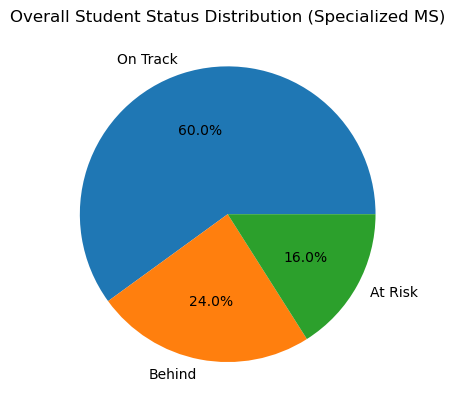

In [6]:
import matplotlib.pyplot as plt

# ---- Overall status distribution ----
status_counts = df["status"].value_counts()

plt.figure()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
plt.title("Overall Student Status Distribution (Specialized MS)")
plt.show()

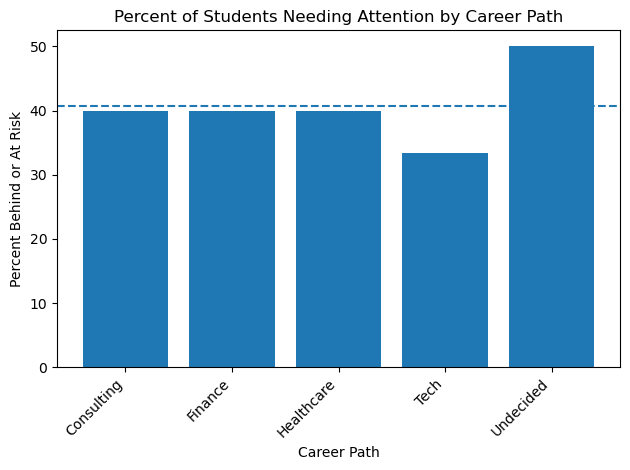

In [10]:
# ---- Percentage of students needing attention by career path ----
attention_rate = (
    df.assign(needs_attention = df["status"].isin(["Behind", "At Risk"]))
      .groupby("career_path")["needs_attention"]
      .mean()
      .reset_index(name="percent_needing_attention")
)

attention_rate["percent_needing_attention"] *= 100

plt.figure()
plt.bar(
    attention_rate["career_path"],
    attention_rate["percent_needing_attention"]
)

avg = attention_rate["percent_needing_attention"].mean()
plt.axhline(avg, linestyle="--")
plt.title("Percent of Students Needing Attention by Career Path")
plt.xlabel("Career Path")
plt.ylabel("Percent Behind or At Risk")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [12]:
# ---- Bottom-line summary by career path ----

summary = (
    df
    .groupby("career_path")
    .agg(
        total_students=("student_id", "count"),
        pct_on_track=("status", lambda x: (x == "On Track").mean()),
        pct_behind=("status", lambda x: (x == "Behind").mean()),
        pct_at_risk=("status", lambda x: (x == "At Risk").mean()),
        pct_no_observable_engagement=("observable_engagement", lambda x: (x == 0).mean())
    )
    .reset_index()
)

# Convert proportions to percentages
for col in summary.columns:
    if col.startswith("pct_"):
        summary[col] = (summary[col] * 100).round(1)

summary

,career_path,total_students,pct_on_track,pct_behind,pct_at_risk,pct_no_observable_engagement
0,Consulting,5,60.0,20.0,20.0,40.0
1,Finance,5,60.0,20.0,20.0,40.0
2,Healthcare,5,60.0,20.0,20.0,60.0
3,Tech,6,66.7,33.3,0.0,50.0
4,Undecided,4,50.0,25.0,25.0,75.0


In [13]:
# ---- Export bottom-line summary ----
summary_path = "../outputs/career_path_bottom_line_v1.csv"
summary.to_csv(summary_path, index=False)

summary_path

'../outputs/career_path_bottom_line_v1.csv'

## How to interpret this summary and act on it

This table provides a bottom-line view of student progress and visibility by
career path for Specialized MS programs and is intended to support
operational decision-making.

**Key takeaways and actions:**

- Career paths with higher **pct_behind** or **pct_at_risk** indicate where
  students may benefit from additional structure, such as clearer timelines,
  targeted workshops, or milestone-based communication.

- Career paths with high **pct_no_observable_engagement** highlight areas
  where Career Services lacks visibility, suggesting the need for improved
  outreach, clearer entry points, or better-aligned marketing rather than
  increased advising pressure.

- Career paths with relatively high **pct_on_track** suggest that existing
  programming and communication are effective and may not require immediate
  additional resources.

Because this analysis is based on synthetic data, the specific percentages
are illustrative. The value of the framework lies in how it enables Career
Services to prioritize limited resources, tailor support by career path, and
intervene earlier with the *right type* of help rather than reactive or
generic outreach.

## Executive Conclusions (V1)

This analysis provides clear, actionable guidance for how Career Services
should prioritize support across Specialized MS career paths, given limited
staff capacity and varying levels of student engagement.

### Key conclusions and actions

**1. Undecided students require immediate priority**
- Undecided students show the lowest percentage On Track (50%), the highest
  At Risk rate (25%), and the highest lack of observable engagement (75%).
- This combination indicates compounding risk driven by uncertainty and
  limited interaction with Career Services resources.

**Action:**  
Prioritize early-stage career exploration programming, low-friction
“start here” messaging, and clearer entry points into Career Services for
undecided students.

---

**2. Healthcare students present an engagement visibility challenge**
- While 60% of healthcare-track students are On Track, 60% show no observable
  engagement with Career Services.
- This suggests students may be navigating recruiting independently or do
  not perceive existing resources as relevant.

**Action:**  
Improve the visibility and positioning of healthcare-relevant resources,
clarify how Career Services supports non-traditional recruiting paths, and
pilot lighter-touch engagement strategies.

---

**3. Consulting and Finance students need timeline reinforcement, not exploration**
- Both paths show stable outcomes (60% On Track) with moderate Behind and
  At Risk rates (40% combined).
- Engagement levels are higher than in other paths, indicating awareness but
  potential slippage against structured recruiting timelines.

**Action:**  
Maintain current programming while reinforcing milestone-based reminders,
application readiness checkpoints, and interview preparation aligned to
recruiting cycles.

---

**4. Tech students are largely self-sufficient**
- Tech students have the highest On Track rate (66.7%) and no students
  classified as At Risk, despite moderate lack of observable engagement (50%).
- This pattern suggests autonomy rather than disengagement.

**Action:**  
Shift tech support toward optional, self-service resources and on-demand
assistance rather than proactive outreach.

---

### Overall takeaway

This framework enables Career Services to move from broad, generic outreach
to targeted, data-informed prioritization. Rather than increasing advising
pressure uniformly, the results support differentiated strategies by career
path; focusing exploration where clarity is lacking, structure where timelines
matter most, and restraint where students are already succeeding.

While the data used here is synthetic, the conclusions demonstrate how this
approach can support intentional decision-making, more effective programming,
and improved student outcomes under real institutional constraints.